# Jonathan Halverson
# Thursday, December 28, 2017
# Denoising autoencoders

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [42]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


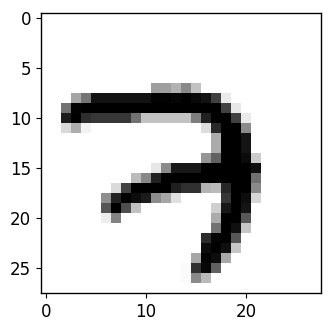

In [43]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')

## Method 1: Add Gaussian noise

### Create the graph

In [4]:
tf.reset_default_graph()

In [5]:
n_inputs = 28 * 28
n_hidden_1 = 300
n_hidden_2 = 144
n_hidden_3 = n_hidden_1
n_outputs = n_inputs
strength = 1.0
l2_reg = 0.0001

In [6]:
from functools import partial

X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs))
X_noise = X + strength * tf.random_normal(shape=tf.shape(X), dtype=tf.float32, name='inputs')
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)
hidden1 = my_dense_layer(X_noise, n_hidden_1, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_hidden_2, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_hidden_3, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [7]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
total_loss = tf.add_n([reconstruction_loss] + reg_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(total_loss)

In [8]:
saver = tf.train.Saver()

In [9]:
init = tf.global_variables_initializer()

### Run the graph

In [10]:
batch_size = 200
epochs = 20
codings = hidden2

In [11]:
ckpt_path = '/tmp/data/final_denoise.ckpt'
with tf.Session() as sess:
     init.run()
     print '-', total_loss.eval(feed_dict={X:mnist.validation.images})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, total_loss.eval(feed_dict={X:mnist.validation.images}), reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

- 1.86521
0 0.062947 0.0609396
2 0.0607987 0.0591392
4 0.060327 0.0588821
6 0.0578252 0.0565409
8 0.0458536 0.0446236
10 0.042383 0.0411597
12 0.0412399 0.0400433
14 0.0404529 0.0392221
16 0.039898 0.0386779
18 0.0394832 0.0382537
20 0.0392302 0.0379919


In [33]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

INFO:tensorflow:Restoring parameters from /tmp/data/final_denoise.ckpt


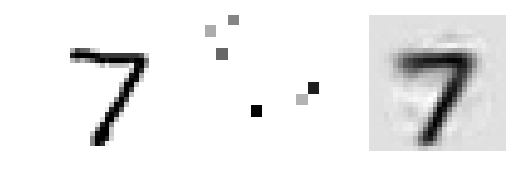

In [13]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(12, 12), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [14]:
from sklearn.linear_model import LogisticRegression

Accuracy when all the data is used:

In [32]:
LogisticRegression(C=1.0).fit(X_train, y_train).score(X_test, y_test)

0.91979999999999995

In [15]:
LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

0.69940000000000002

In [16]:
codings_train.shape

(55000, 144)

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='log')
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.66569999999999996

## Method 2: Dropout

In [18]:
tf.reset_default_graph()

In [19]:
n_inputs = 28 * 28
n_units = n_inputs
n_outputs = n_inputs
keep_prob = 0.5

In [20]:
from functools import partial

training = tf.placeholder_with_default(False, shape=(None), name='training')
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs))
X_dropout = tf.layers.dropout(X, keep_prob, training=training)

he_init = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.relu, kernel_initializer=he_init)
hidden1 = my_dense_layer(X_dropout, n_units, name='hidden1')
hidden2 = my_dense_layer(hidden1, n_units, name='hidden2')
hidden3 = my_dense_layer(hidden2, n_units, name='hidden3')
outputs = my_dense_layer(hidden3, n_outputs, activation=None, name='outputs')

In [22]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [23]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [24]:
batch_size = 200
epochs = 20
codings = hidden2

In [25]:
ckpt_path = '/tmp/data/final_dropout.ckpt'
with tf.Session() as sess:
     init.run()
     print '-', reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, training:True})
          if not (epoch % 2): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

- 0.339828
0 0.0236503
2 0.0164853
4 0.0146424
6 0.0138861
8 0.0130864
10 0.0123178
12 0.0118362
14 0.0114569
16 0.0111485
18 0.0107434
20 0.0103889


INFO:tensorflow:Restoring parameters from /tmp/data/final_dropout.ckpt


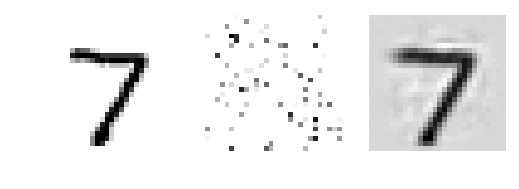

In [26]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     plt.imshow(codings_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

In [27]:
sgd_clf = SGDClassifier(random_state=42, tol=1e-4, loss='log')
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.95469999999999999

In [28]:
LogisticRegression(C=0.1).fit(codings_train, y_train).score(codings_test, y_test)

0.95940000000000003

In [29]:
LogisticRegression(C=1.0).fit(codings_train, y_train).score(codings_test, y_test)

0.96230000000000004

In [30]:
LogisticRegression(C=10.0).fit(codings_train, y_train).score(codings_test, y_test)

0.96250000000000002

We see that the features generated with the autoencoder using dropout gave the best performance in terms of accuracy. Recall, here is the accuracy when all the data is used:

In [34]:
LogisticRegression(C=1.0).fit(X_train, y_train).score(X_test, y_test)

0.91979999999999995

This is the case where creating new features improves the performance of the model.

In [37]:
mnist.train.images.shape

(55000, 784)

In [40]:
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [41]:
LogisticRegression(C=1.0).fit(X_train_std, y_train).score(X_test_std, y_test)

0.91700000000000004

### Discussion

When dropout is used we keep the number of neurons per hidden layer the same as the number of input and (of course) output neurons. When the codings are used to fit a model instead of the original 784 features per digit, the performance is very good (96% versus 92% when the autoencoder is not used). This is a surprising result.

When adding Gaussian noise is tried along with undercompletion, the performance of the autoencoder is very not good giving only 70% accuracy when the codings are used for classification. In general there is much more to be done here.